In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'LinearBaselineModel_OneHot'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
# Create list of columns that can reasonably be one-hot-encoded
one_hot_cols = [
    'borough',
    'neighborhood',
    'zip_code',
    'tax_class_at_time_of_sale',
    'tax_class_at_present',
    'tax_class_at_present_prefix',
    'building_class_category',
    'building_class_at_time_of_sale',
    'building_class_at_time_of_sale_prefix',
    'building_class_at_present',
    'building_class_at_present_prefix'
    ]

In [9]:
# Define dataset parameters
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': OneHotEncoder(cols=one_hot_cols),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [10]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [11]:
# Define model architecture
class LinearBaselineModel_OneHot(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define linear model
        self.TextModel = nn.Linear(dataset.X_text.shape[1], 1)

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [12]:
# Instantiate model
model = LinearBaselineModel_OneHot().to(device)

In [13]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 809


In [14]:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=torch.optim.SGD(model.parameters(), lr=.001),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=50,
    patience=50,
    delta=0,
    batch_size=2048,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 21/21 [00:00<00:00, 67.15it/s]


Epoch  1/50: RMSE_train: 1,694,882, RMSE_val: 1,643,556


100%|██████████| 21/21 [00:00<00:00, 87.72it/s] 


Epoch  2/50: RMSE_train: 1,617,222, RMSE_val: 1,578,721


100%|██████████| 21/21 [00:00<00:00, 123.27it/s]


Epoch  3/50: RMSE_train: 1,568,915, RMSE_val: 1,524,123


100%|██████████| 21/21 [00:00<00:00, 90.18it/s]


Epoch  4/50: RMSE_train: 1,520,662, RMSE_val: 1,475,494


100%|██████████| 21/21 [00:00<00:00, 92.61it/s]


Epoch  5/50: RMSE_train: 1,470,555, RMSE_val: 1,436,826


100%|██████████| 21/21 [00:00<00:00, 88.90it/s] 


Epoch  6/50: RMSE_train: 1,430,648, RMSE_val: 1,396,814


100%|██████████| 21/21 [00:00<00:00, 89.53it/s] 


Epoch  7/50: RMSE_train: 1,398,854, RMSE_val: 1,362,538


100%|██████████| 21/21 [00:00<00:00, 91.15it/s] 


Epoch  8/50: RMSE_train: 1,361,763, RMSE_val: 1,333,345


100%|██████████| 21/21 [00:00<00:00, 121.48it/s]


Epoch  9/50: RMSE_train: 1,331,670, RMSE_val: 1,305,770


100%|██████████| 21/21 [00:00<00:00, 89.72it/s]


Epoch 10/50: RMSE_train: 1,309,693, RMSE_val: 1,278,891


100%|██████████| 21/21 [00:00<00:00, 90.39it/s]


Epoch 11/50: RMSE_train: 1,279,775, RMSE_val: 1,254,765


100%|██████████| 21/21 [00:00<00:00, 91.67it/s]


Epoch 12/50: RMSE_train: 1,250,210, RMSE_val: 1,234,177


100%|██████████| 21/21 [00:00<00:00, 89.88it/s] 


Epoch 13/50: RMSE_train: 1,231,537, RMSE_val: 1,216,411


100%|██████████| 21/21 [00:00<00:00, 109.63it/s]


Epoch 14/50: RMSE_train: 1,211,827, RMSE_val: 1,196,674


100%|██████████| 21/21 [00:00<00:00, 90.74it/s]


Epoch 15/50: RMSE_train: 1,191,256, RMSE_val: 1,182,695


100%|██████████| 21/21 [00:00<00:00, 89.17it/s]


Epoch 16/50: RMSE_train: 1,170,517, RMSE_val: 1,161,507


100%|██████████| 21/21 [00:00<00:00, 89.49it/s]


Epoch 17/50: RMSE_train: 1,163,856, RMSE_val: 1,148,475


100%|██████████| 21/21 [00:00<00:00, 89.54it/s] 


Epoch 18/50: RMSE_train: 1,140,036, RMSE_val: 1,137,439


100%|██████████| 21/21 [00:00<00:00, 89.94it/s] 


Epoch 19/50: RMSE_train: 1,130,156, RMSE_val: 1,122,052


100%|██████████| 21/21 [00:00<00:00, 123.62it/s]


Epoch 20/50: RMSE_train: 1,116,738, RMSE_val: 1,113,012


100%|██████████| 21/21 [00:00<00:00, 90.10it/s]


Epoch 21/50: RMSE_train: 1,108,290, RMSE_val: 1,102,227


100%|██████████| 21/21 [00:00<00:00, 88.77it/s]


Epoch 22/50: RMSE_train: 1,099,400, RMSE_val: 1,090,808


100%|██████████| 21/21 [00:00<00:00, 89.03it/s]


Epoch 23/50: RMSE_train: 1,083,910, RMSE_val: 1,083,104


100%|██████████| 21/21 [00:00<00:00, 89.21it/s] 


Epoch 24/50: RMSE_train: 1,081,447, RMSE_val: 1,072,653


100%|██████████| 21/21 [00:00<00:00, 90.29it/s] 


Epoch 25/50: RMSE_train: 1,061,041, RMSE_val: 1,071,204


100%|██████████| 21/21 [00:00<00:00, 125.60it/s]


Epoch 26/50: RMSE_train: 1,058,563, RMSE_val: 1,064,149


100%|██████████| 21/21 [00:00<00:00, 88.97it/s]


Epoch 27/50: RMSE_train: 1,045,334, RMSE_val: 1,058,952


100%|██████████| 21/21 [00:00<00:00, 90.20it/s]


Epoch 28/50: RMSE_train: 1,045,524, RMSE_val: 1,051,179


100%|██████████| 21/21 [00:00<00:00, 89.68it/s]


Epoch 29/50: RMSE_train: 1,039,760, RMSE_val: 1,043,574


100%|██████████| 21/21 [00:00<00:00, 89.09it/s] 


Epoch 30/50: RMSE_train: 1,034,001, RMSE_val: 1,042,536


100%|██████████| 21/21 [00:00<00:00, 120.85it/s]


Epoch 31/50: RMSE_train: 1,033,751, RMSE_val: 1,034,297


100%|██████████| 21/21 [00:00<00:00, 89.49it/s]


Epoch 32/50: RMSE_train: 1,024,690, RMSE_val: 1,031,964


100%|██████████| 21/21 [00:00<00:00, 90.32it/s]


Epoch 33/50: RMSE_train: 1,029,009, RMSE_val: 1,027,510


100%|██████████| 21/21 [00:00<00:00, 90.92it/s]


Epoch 34/50: RMSE_train: 1,019,559, RMSE_val: 1,023,678


100%|██████████| 21/21 [00:00<00:00, 90.86it/s] 


Epoch 35/50: RMSE_train: 1,011,208, RMSE_val: 1,018,272


100%|██████████| 21/21 [00:00<00:00, 90.22it/s] 


Epoch 36/50: RMSE_train: 1,006,932, RMSE_val: 1,018,306
EarlyStopping counter: 1 out of 50


100%|██████████| 21/21 [00:00<00:00, 121.65it/s]


Epoch 37/50: RMSE_train: 1,006,587, RMSE_val: 1,014,644


100%|██████████| 21/21 [00:00<00:00, 124.70it/s]


Epoch 38/50: RMSE_train: 996,664, RMSE_val: 1,011,925


100%|██████████| 21/21 [00:00<00:00, 88.92it/s]


Epoch 39/50: RMSE_train: 994,400, RMSE_val: 1,012,366
EarlyStopping counter: 1 out of 50


100%|██████████| 21/21 [00:00<00:00, 123.85it/s]


Epoch 40/50: RMSE_train: 996,447, RMSE_val: 1,010,086


100%|██████████| 21/21 [00:00<00:00, 90.96it/s]


Epoch 41/50: RMSE_train: 990,829, RMSE_val: 1,005,817


100%|██████████| 21/21 [00:00<00:00, 84.19it/s] 


Epoch 42/50: RMSE_train: 985,435, RMSE_val: 1,005,704


100%|██████████| 21/21 [00:00<00:00, 88.35it/s] 


Epoch 43/50: RMSE_train: 982,619, RMSE_val: 1,002,688


100%|██████████| 21/21 [00:00<00:00, 89.15it/s] 


Epoch 44/50: RMSE_train: 982,218, RMSE_val: 1,002,796
EarlyStopping counter: 1 out of 50


100%|██████████| 21/21 [00:00<00:00, 125.11it/s]


Epoch 45/50: RMSE_train: 984,600, RMSE_val: 1,003,229
EarlyStopping counter: 2 out of 50


100%|██████████| 21/21 [00:00<00:00, 89.94it/s]


Epoch 46/50: RMSE_train: 981,511, RMSE_val: 998,303


100%|██████████| 21/21 [00:00<00:00, 88.47it/s]


Epoch 47/50: RMSE_train: 980,376, RMSE_val: 1,002,955
EarlyStopping counter: 1 out of 50


100%|██████████| 21/21 [00:00<00:00, 91.76it/s]


Epoch 48/50: RMSE_train: 982,781, RMSE_val: 997,281


100%|██████████| 21/21 [00:00<00:00, 92.64it/s] 


Epoch 49/50: RMSE_train: 981,477, RMSE_val: 995,934


100%|██████████| 21/21 [00:00<00:00, 120.89it/s]


Epoch 50/50: RMSE_train: 975,199, RMSE_val: 1,001,003
EarlyStopping counter: 1 out of 50


In [15]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [16]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   977080.916  546132.008  0.766  0.388
val     998451.061  538287.647  0.746  0.349
test    981880.874  536032.748  0.715  0.377
--------------------------------------------
total   980198.441  543327.834  0.754  0.382


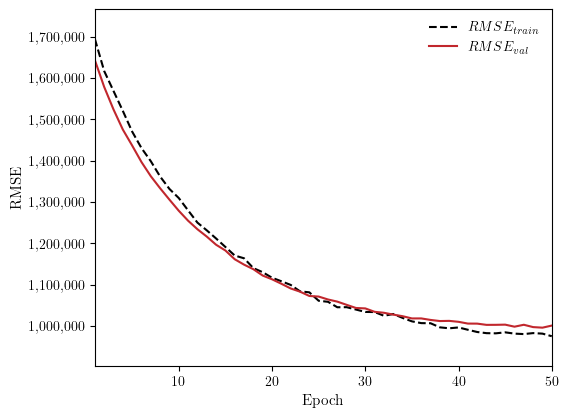

In [17]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

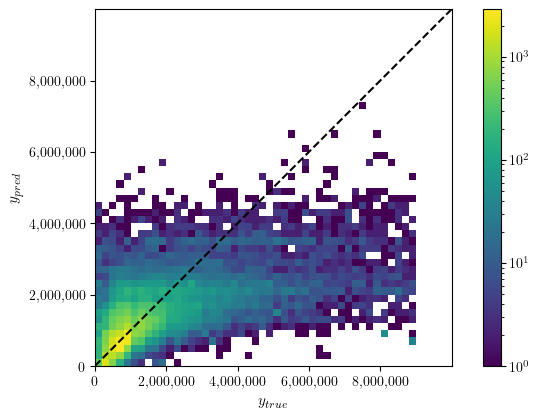

In [18]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')